In [1]:
!pip install torch-snippets==0.426

     |████████████████████████████████| 208 kB 10.3 MB/s 
     |████████████████████████████████| 54 kB 3.7 MB/s 
     |████████████████████████████████| 57 kB 6.2 MB/s 
     |████████████████████████████████| 51 kB 9.1 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from torch_snippets import *
from PIL import Image
#IMAGE_ROOT = 'C:/Users/WALL-E/Documents/Diplomado/Vision Artificial/Coleccion-de-imagenes-master/Coleccion-de-imagenes-master/Imagenes'
#DF_RAW = df = pd.read_csv('C:/Users/WALL-E/Documents/Diplomado/Vision Artificial/proyecto/df_raw.csv')
IMAGE_ROOT = '/content/drive/MyDrive/DIPLOMADO/Vision Artificial/Data/Imagenes'
DF_RAW = df = pd.read_csv('/content/drive/MyDrive/DIPLOMADO/Vision Artificial/Data/df_raw.csv')

2021-08-04 14:44:18.982 | WARNING  | torch_snippets.torch_loader:<module>:233 - Not importing Lightning Report
2021-08-04 14:44:19.543 | WARNING  | torch_snippets:<module>:13 - sklearn is not found. Skipping relevant imports from submodule `sklegos`
Exception: No module named 'sklego'


In [4]:
#Normalizing these coordinates means you rescale them to the 0-1 range, by dividing by the image width and height.
DF_RAW['xmin']=DF_RAW['xmin']/DF_RAW['width']
DF_RAW['xmax']=DF_RAW['xmax']/DF_RAW['width']

DF_RAW['ymin']=DF_RAW['ymin']/DF_RAW['height']
DF_RAW['ymax']=DF_RAW['ymax']/DF_RAW['height']

DF_RAW

,filename,width,height,depth,label,pose,truncated,difficult,xmin,ymin,xmax,ymax
0,imagen_0001.png,1280,720,3,Excavadora,NaN,0,0,0.461719,0.448611,0.914062,0.787500
1,imagen_0001.png,1280,720,3,Auto,NaN,0,0,0.019531,0.661111,0.250000,0.925000
2,imagen_0002.png,1280,720,3,Excavadora,NaN,0,0,0.220312,0.252778,0.948438,0.768056
3,imagen_0003.png,1280,720,3,Excavadora,NaN,0,0,0.364844,0.322222,0.570312,0.688889
4,imagen_0004.png,1280,720,3,Excavadora,NaN,1,0,0.000781,0.043056,0.489063,0.498611
...,...,...,...,...,...,...,...,...,...,...,...,...
5502,imagen_1572.png,3840,2160,3,Camion_minero,NaN,0,0,0.538281,0.711574,0.602604,0.804167
5503,imagen_1572.png,3840,2160,3,Camion,NaN,0,0,0.067448,0.372222,0.084635,0.398148
5504,imagen_1572.png,3840,2160,3,Bulldozer,NaN,1,0,0.913802,0.849537,1.000000,0.922222
5505,imagen_1572.png,3840,2160,3,Excavadora,NaN,0,0,0.527344,0.496759,0.634115,0.701389


In [5]:
from torch_snippets import *

df = df[df['filename'].isin(df['filename'].unique().tolist())]

label2target = {l:t+1 for t,l in enumerate(DF_RAW['label'].unique())}
label2target['background'] = 0
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
import collections, os, torch
from PIL import Image
from torchvision import transforms
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
denormalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    return img.to(device).float()
    
class OpenDataset(torch.utils.data.Dataset):
    w, h = 300, 300
    def __init__(self, df, image_dir=IMAGE_ROOT):
        self.image_dir = image_dir
        self.files = glob.glob(self.image_dir+'/*')
        self.df = df
        self.image_infos = os.listdir(self.image_dir)
        logger.info(f'{len(self)} items loaded')
        
    def __getitem__(self, ix):
        # load images and masks
        image_id = self.image_infos[ix]
        img_path = find(image_id, self.files)
        img = Image.open(img_path).convert("RGB")
        img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR))/255.
        data = df[df['filename'] == image_id]
        labels = data['label'].values.tolist()
        data = data[['xmin','ymin','xmax','ymax']].values
        data[:,[0,2]] *= self.w
        data[:,[1,3]] *= self.h
        boxes = data.astype(np.uint32).tolist() # convert to absolute coordinates
        return img, boxes, labels

    def collate_fn(self, batch):
        images, boxes, labels = [], [], []
        for item in batch:
            img, image_boxes, image_labels = item
            img = preprocess_image(img)[None]
            images.append(img)
            boxes.append(torch.tensor(image_boxes).float().to(device)/300.)
            labels.append(torch.tensor([label2target[c] for c in image_labels]).long().to(device))
        images = torch.cat(images).to(device)
        return images, boxes, labels
    def __len__(self):
        return len(self.image_infos)

In [7]:
#image_paths = Glob(f'{IMAGE_ROOT}/images/*')
#for _ in range(1):
  #  image_id = choose(test_ds.image_infos)
 #   img_path = find(image_id, test_ds.files)
  #  original_image = Image.open(img_path, mode='r')
  #  image = preprocess_image(original_image)
  #  show(original_image,text_sz=10)
  #  show(image,text_sz=10)

In [8]:
from sklearn.model_selection import train_test_split
trn_ids, val_ids = train_test_split(df.filename.unique(), test_size=0.1, random_state=99, shuffle=True)
trn_df, val_df = df[df['filename'].isin(trn_ids)], df[df['filename'].isin(val_ids)]
len(trn_df), len(val_df)

train_ds = OpenDataset(trn_df)
test_ds = OpenDataset(val_df)

train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4, collate_fn=test_ds.collate_fn, drop_last=True)

2021-08-04 14:44:27.957 | INFO     | __main__:__init__:25 - 1572 items loaded
2021-08-04 14:44:27.975 | INFO     | __main__:__init__:25 - 1572 items loaded


In [9]:
def train_batch(inputs, model, criterion, optimizer):
    model.train()
    N = len(train_loader)
    images, boxes, labels = inputs
    _regr, _clss = model(images)
    loss = criterion(_regr, _clss, boxes, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss
    
@torch.no_grad()
def validate_batch(inputs, model, criterion):
    model.eval()
    images, boxes, labels = inputs
    _regr, _clss = model(images)
    loss = criterion(_regr, _clss, boxes, labels)
    return loss

In [10]:
from model import SSD300, MultiBoxLoss
from detect import *

In [11]:
n_epochs = 25

model = SSD300(num_classes, device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy, device=device)

log = Report(n_epochs=n_epochs)
logs_to_print = 5

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth




Loaded base model.



/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [12]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss = train_batch(inputs, model, criterion, optimizer)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        loss = validate_batch(inputs, model, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), end='\r')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


EPOCH: 25.000	val_loss: 0.432	(10565.24s - 0.00s remaining)

100%|██████████| 126/126 [00:00<00:00, 176.13it/s]


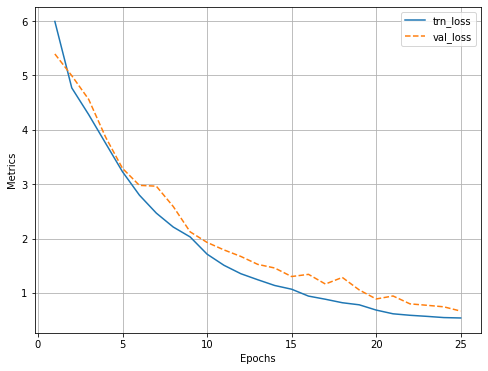

In [13]:
log.plot_epochs('trn_loss,val_loss'.split(','))


In [14]:
image_paths = Glob(f'{IMAGE_ROOT}/images/*')
image_id = choose(test_ds.image_infos)
img_path = find(image_id, test_ds.files)
original_image = Image.open(img_path, mode='r')
original_image = original_image.convert('RGB')

2021-08-04 17:41:17.054 | INFO     | __main__:<module>:1 - 0 files found at /content/drive/MyDrive/DIPLOMADO/Vision Artificial/Data/Imagenes/images/*


In [15]:
image_paths = Glob(f'{IMAGE_ROOT}/images/*')
for _ in range(3):
    image_id = choose(test_ds.image_infos)
    img_path = find(image_id, test_ds.files)
    original_image = Image.open(img_path, mode='r')
    bbs, labels, scores = detect(original_image, model, min_score=0.9, max_overlap=0.5,top_k=200, device=device)
    labels = [target2label[c.item()] for c in labels]
    label_with_conf = [f'{l} @ {s:.2f}' for l,s in zip(labels,scores)]
    print(bbs, label_with_conf)
    show(original_image, bbs=bbs, texts=label_with_conf, text_sz=10)


Output hidden; open in https://colab.research.google.com to view.

In [16]:
for _ in range(3):
    image_id = choose(test_ds.image_infos)
    img_path = find(image_id, test_ds.files)
    original_image = Image.open(img_path, mode='r')
    bbs, labels, scores = detect(original_image, model, min_score=0.9, max_overlap=0.5,top_k=200, device=device)
    labels = [target2label[c.item()] for c in labels]
    label_with_conf = [f'{l} @ {s:.2f}' for l,s in zip(labels,scores)]
    print(bbs, label_with_conf)
    show(original_image, bbs=bbs, texts=label_with_conf, text_sz=10)


Output hidden; open in https://colab.research.google.com to view.

In [17]:
torch.save(model, 'modelssdCOPY.pth')

In [19]:
# save 
import pickle

with open('/content/drive/MyDrive/DIPLOMADO/Vision Artificial/models/SSD/label2targetCOPY.txt','wb') as fp:
  pickle.dump(label2target,fp)

with open('/content/drive/MyDrive/DIPLOMADO/Vision Artificial/models/SSD/target2labelCOPY.txt','wb') as fp:
  pickle.dump(target2label,fp)

In [ ]:
test_ds[]

In [ ]:
## Crea la lista de prediciones para el conjunto de prueba
pred_boxes = [] # [idx_image, class_prediction, prob_score, x1, y1, x2, y2]
true_boxes = [] # [idx_image, class, x1, y1, x2, y2]

for _,_,_,_,_, fpath in test_ds: ## image, rois, labels, deltas, gtbbs, fpath
  filename = fpath.split('/')[-1]
  df_bbs = df[df.filename == filename ]
  boxes = df_bbs[['filename','label','xmin','ymin','xmax','ymax']].values
  img = cv2.imread(fpath,1)[...,::-1]
  H,W,_= img.shape
  gtbbs = boxes[:,2:] *224.0/ np.array([W,H,W,H])
  gtbbs = gtbbs.astype(np.int32)
  boxes[:,2:] =  gtbbs
  #print(H,W)
  #print(gtbbs)
  pred_confs, pred_clss , pred_bbs = test_predictions(fpath,show_image=False)
  if len(pred_confs) == 0 : continue
  predictions =  [[filename,target2label[pred_cls],conf,*pred_bb ] for pred_cls, conf, pred_bb in zip( pred_clss ,pred_confs, pred_bbs)]
  pred_boxes.extend(predictions)
  true_boxes.extend(boxes)